In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [5]:
x_train.min(), x_train.max()

(-1.0, 1.0)

In [6]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

In [7]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import model_to_dot

In [8]:
NOISE_DIM = 10

adam = Adam(lr=0.0002, beta_1=0.5)

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

# Activation Func = tanh !!

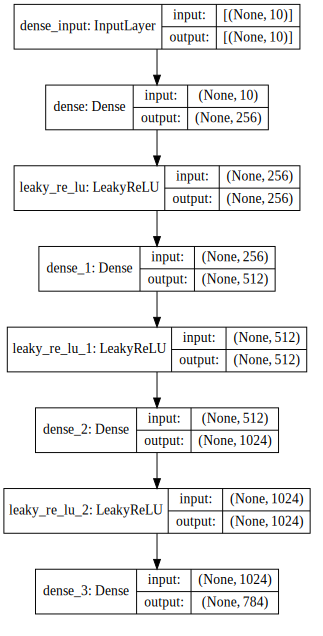

In [23]:
#generator.summary()
SVG(model_to_dot(generator, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

SVG

In [11]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

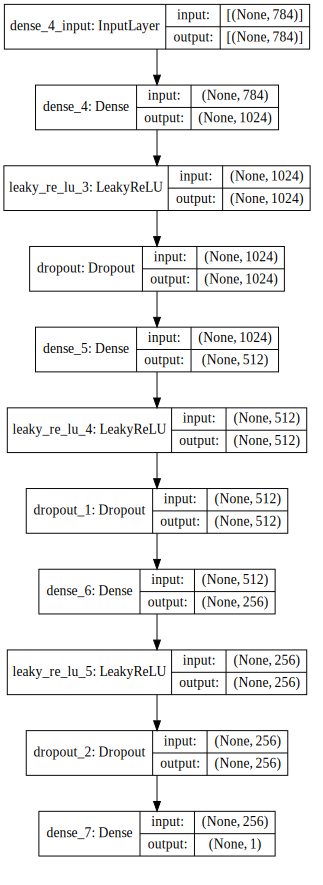

In [22]:
#discriminator.summary() #, show_shapes=True
SVG(model_to_dot(discriminator, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [25]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [26]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [27]:
gan = Model(gan_input, output)

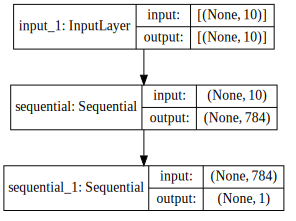

In [30]:
#gan.summary()
SVG(model_to_dot(gan, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [31]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [32]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [33]:
def visualize_training(epoch, d_losses, g_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [34]:
BATCH_SIZE = 128
EPOCHS= 50

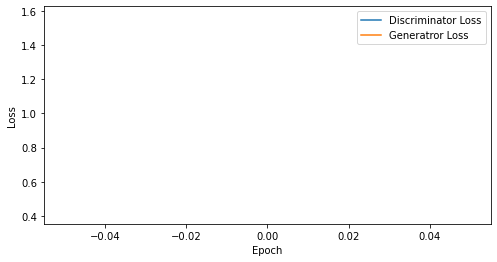

epoch: 1, Discriminator Loss: 0.41236644983291626, Generator Loss: 1.5687061548233032


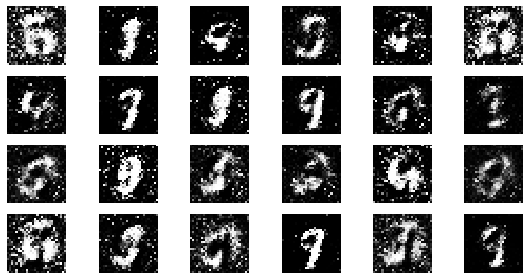

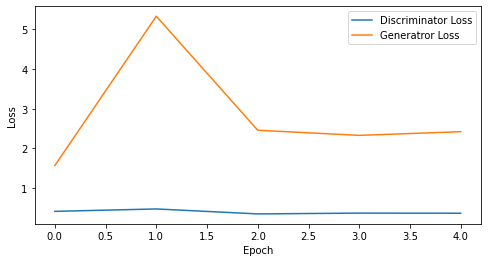

epoch: 5, Discriminator Loss: 0.39298502206802366, Generator Loss: 2.8218474626541137


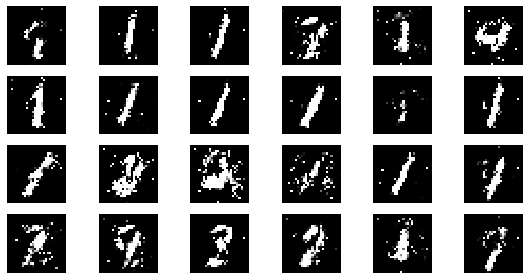

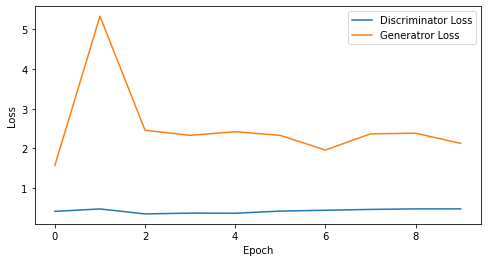

epoch: 10, Discriminator Loss: 0.4233127415180206, Generator Loss: 2.5273176074028014


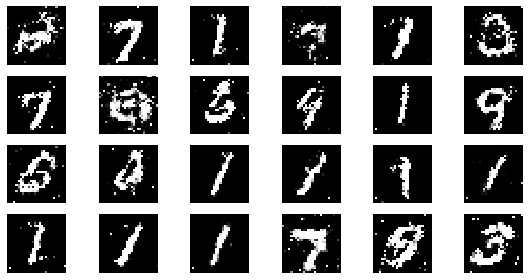

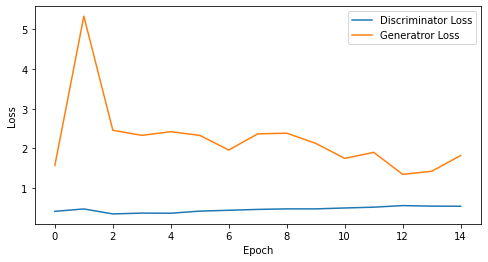

epoch: 15, Discriminator Loss: 0.4593222717444102, Generator Loss: 2.233942413330078


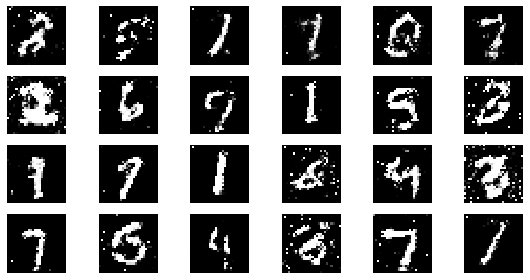

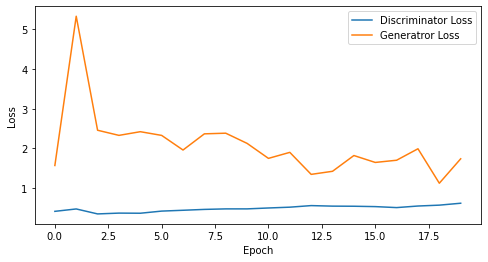

epoch: 20, Discriminator Loss: 0.4830454722046852, Generator Loss: 2.0853205919265747


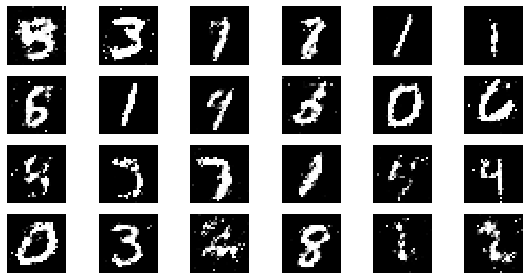

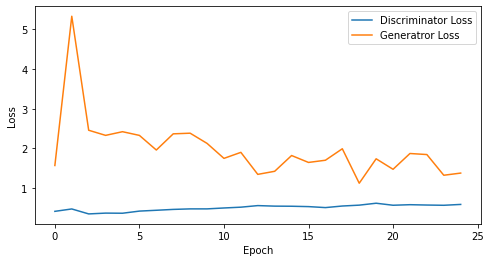

epoch: 25, Discriminator Loss: 0.5012228667736054, Generator Loss: 1.9838204669952393


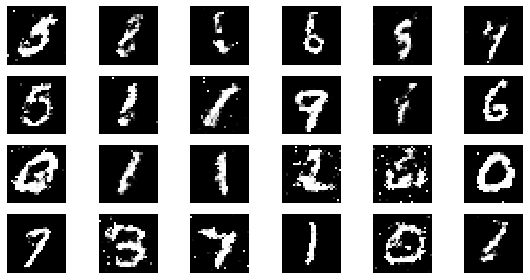

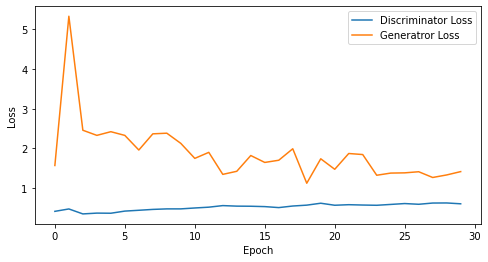

epoch: 30, Discriminator Loss: 0.5192681262890498, Generator Loss: 1.8800466537475586


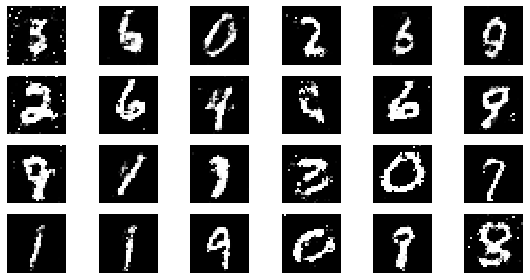

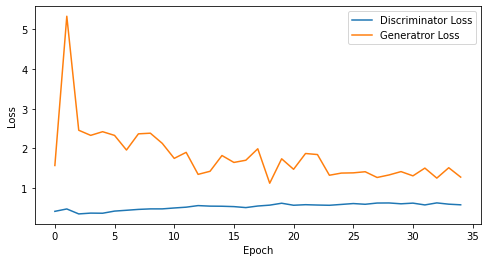

epoch: 35, Discriminator Loss: 0.5304948798247746, Generator Loss: 1.8071487733295986


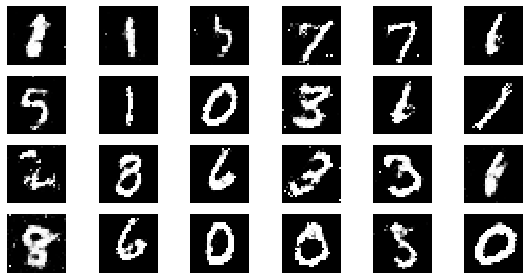

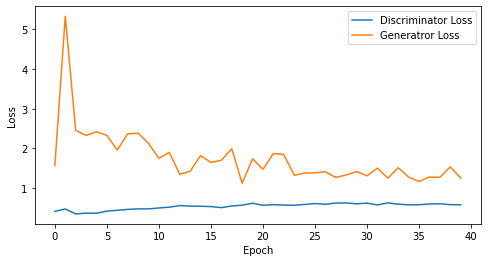

epoch: 40, Discriminator Loss: 0.5376747660338879, Generator Loss: 1.743844810128212


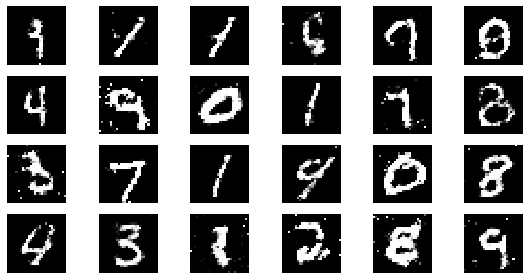

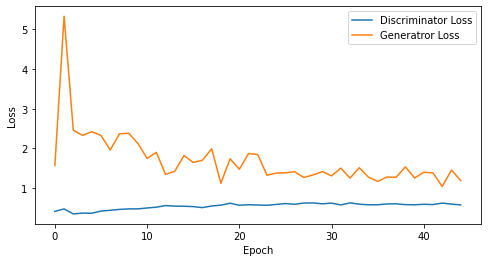

epoch: 45, Discriminator Loss: 0.5438151101271311, Generator Loss: 1.693668344285753


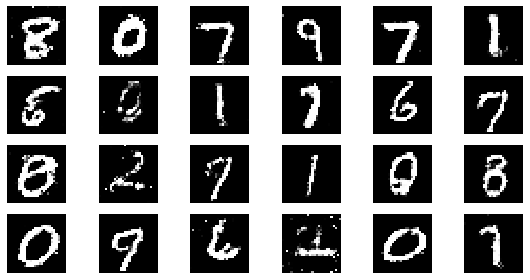

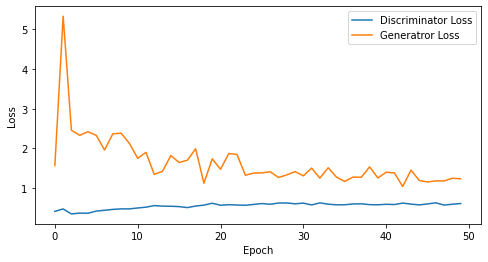

epoch: 50, Discriminator Loss: 0.5494043058156968, Generator Loss: 1.644213194847107


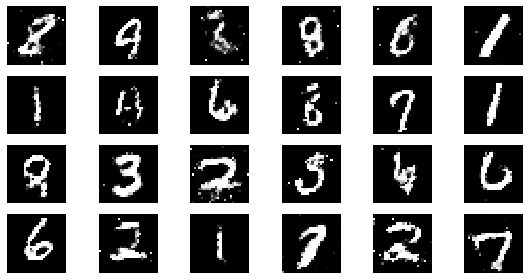

In [35]:
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    for real_images in get_batches(x_train, BATCH_SIZE):
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        generated_images = generator.predict(input_noise)
        
        x_dis = np.concatenate([real_images, generated_images])
        
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)